# 2. Diffusion

We attempt to integrate numerically the equation
\begin{equation}
    \frac{\partial T(x, t)}{\partial t} = \frac{K}{C \rho} \frac{\partial^{2}T}{\partial x^{2}},
\end{equation}


# a) FTCS


The Forward Time Centered Space scheme (FTCS), as indicated by the name, uses a Forward Difference for time derivatives together with an Euler method (setting the function at time $t_{n}$) and a Central Finite Difference for spatial derivatives. Thus, for the diffusion equation we have

\begin{equation}
    \frac{\partial T}{\partial t} = F(t, x, \partial_{x}^{2}T) \implies \frac{\partial T}{\partial t} \overset{\text{F.D.}}{\approx} \frac{T(t_{n + 1}, x_{j}) - T(t_{n}, x_{j})}{\Delta t} \qquad \frac{T(t_{n + 1}, x_{j}) - T(t_{n}, x_{j})}{\Delta t} = F\left(t_{n}, x_{i}, \partial_{x}^{2}T(t_{n}, x_{i})\right) \quad \text{Euler method for time.}
\end{equation}

Then, for space, we use the given form of $F(t, x, \partial_{x}^{2}T)$ to obtain

\begin{equation}
    \frac{\partial^{2}T}{\partial x^{2}}(t_{n}, x_{j}) \overset{\text{C.F.D.}}{\approx} \frac{T(t_{n}, x_{j + 1}) - 2 T(t_{n}, x_{j}) + T(t_{n}, x_{j - 1})}{(\Delta x)^{2}}
\end{equation}

Hence, the equation discretized with a FTCS scheme reads

\begin{equation}
    \boxed{\frac{T(t_{n + 1}, x_{j}) - T(t_{n}, x_{j})}{\Delta t} = \frac{K}{C \rho} \frac{T(t_{n}, x_{j + 1}) - 2 T(t_{n}, x_{j}) + T(t_{n}, x_{j - 1})}{(\Delta x)^{2}}.}
\end{equation}

The next step is to apply our initial and boundary conditions:

\begin{align}
    t_{0} & = 0 & T(0, x) & = \sin{(\pi x/L)} \implies T(t_{0}, x_{j}) = \sin{(\pi x_{j}/L)} \quad \forall j \\
    x_{0} & = 0 & T(t, 0) & = 0 \implies T(t_{n}, x_{0}) = 0 \quad \forall n \\
    x_{N} & = L & T(t, 1) & = 0 \implies T(t_{n}, x_{N}) = 0 \quad \forall n
\end{align}

Thus, we can now obtain the value of the temperature at each point for every future time

\begin{equation}
    \boxed{T(t_{n + 1}, x_{j}) = T(t_{n}, x_{j}) + \frac{K}{C\rho}\frac{\Delta t}{(\Delta x)^{2}}\left(T(t_{n}, x_{j + 1}) - 2 T(t_{n}, x_{j}) + T(t_{n}, x_{j - 1})\right)}
\end{equation}

## Algorithm

Input parameters:
* Dimension of the grid (In this case it is one dimensional because we only have one coordinate in space).
* Initial and boundary conditions
* Step size in space and time

Output parameters:
* Temperature profiles at each step in time, preferably in the form of a matrix with grid points corresponding to different row values and time values corresponding to different column values since Julia loops faster over rows. Note, however, that heatmaps require the transpose of this order to have time along the vertical axis.


# b) Study of the simulation error

In the function for part a) we obtain an array of temperatures with $N_{x} = L/\Delta x$ grid points being evaluated along the rod. For any given time $t$, the average error is given by

\begin{equation}
    \epsilon(t) = \frac{1}{N_{x}} \sum_{j=1}^{N_{x}} \left[T(j\Delta x, t) - T_{\text{exact}}(j\Delta x, t)\right] = \frac{1}{N_{x}} \sum_{j=1}^{N_{x} - 1} \left[T(j\Delta x, t) - T_{\text{exact}}(j\Delta x, t)\right]
\end{equation}

where, since the point $x = L$ is fixed and at no point it is recalculated, its value has no error.

To evaluate the error at the same time $t$ for different values of $\Delta t$ we must evaluate at each of them

\begin{equation}
    N_{t} = \underbrace{t/\Delta t}_{\text{nearest integer}}, \qquad a = \frac{K}{C \rho (\Delta x)^{2}} \cdot \Delta t
\end{equation}

Von Neumann stability analysis applied to the 1-dimensional heat equation consists on substituting 

\begin{equation}
    T_{j}^{n} = \xi^{n} e^{i k j \Delta x}, \qquad k = \frac{\pi m}{L} \quad \text{for $m = -N_{x}, -N_{x} + 1, \dots, 0, \dots, N_{x}-1, N_{x}$}
\end{equation}

and the condition for the error to remain bounded is that $|\xi| \leq 1$. For the FTCS method this translates into

\begin{align}
    T_{j}^{n + 1} & = T_{j}^{n} + \Delta t \frac{K}{C \rho \Delta x^{2}} \frac{T_{j + 1}^{n} - 2 T^{n}_{j} + T^{n}_{j - 1}}{(\Delta x)^{2}} \\
    \xi & = 1 + \Delta t \frac{K}{C \rho \Delta x^{2}}  \left(e^{i k \Delta x} - 2 + e^{-i k \Delta x}\right) = 1 - \Delta t \frac{2 K}{C \rho \Delta x^{2}} \left[1 - \cos(k \Delta x)\right] \\
    |\xi| & \leq 1 \implies -1 \leq \xi \leq 1 \implies \Delta t \frac{2 K}{C \rho \Delta x^{2}} \left[1 - \cos(k \Delta x)\right] \leq 2 \implies \Delta t \leq \frac{C \rho \Delta x^{2}}{K \left[1 - \cos(k \Delta x)\right]}
\end{align}

Thus, in order for all nodes $k$ to have a bounded error, the maximum time step size must satisfy the above inequality for the smallest factor on the right-hand side, which is given by $k = 0$. Hence, 

\begin{equation}
    \Delta t \leq \frac{C \rho \Delta x^{2}}{2 K}.
\end{equation}

For $K = 210$, $C = 900$, $\rho = 2700$ and $\Delta x = 0.01$ this yields $\Delta t \leq 0.57857$.

# c) 
## Implicit Euler backward

With the end points fixed, the general implementation has the following matrix representation:

\begin{equation}
    A \mathbf{T}^{n+1} = \mathbf{T}^{n}, \quad
    A = \begin{pmatrix}
        1 & 0 & 0 & \cdots & \cdots & \cdots & 0\\
        -a & 1 + 2 a & -a & 0 & \cdots & \cdots & 0 \\
        0 & -a & 1 + 2 a & -a & 0 & \cdots &  0 \\
        \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\
        0 & \cdots & \cdots & 0 & -a & 1 + 2 a & -a \\
        0 & \cdots & \cdots & \cdots & 0 & 0 & 1
    \end{pmatrix} \qquad \mathbf{T}^{n} = 
    \begin{pmatrix}
        T_{0}^{n} \\
         \\
        \vdots \\
        \\
        T_{N_{x}}^{n}
    \end{pmatrix}
\end{equation}

or, implementing the boundary conditions $T(0, t) = T(L, t) = 0$,

\begin{equation}
    A \mathbf{T}^{n+1} = \mathbf{T}^{n}, \quad
    A = \begin{pmatrix}
        1 + 2 a & -a & 0 & \cdots &  0 \\
        -a & 1 + 2 a & -a & 0 &  0 \\
        \vdots & \ddots & \ddots & \ddots & \vdots \\
        \vdots &  & \ddots & \ddots & -a \\
        0  & \cdots & 0 & -a & 1 + 2 a
    \end{pmatrix}
    \qquad \mathbf{T}^{n} = 
    \begin{pmatrix}
        T_{1}^{n} \\
         \\
        \vdots \\
        \\
        T_{N_{x}-1}^{n}
    \end{pmatrix}
\end{equation}

Von Neumann stability analysis for the implicit Euler backward scheme gives, for the inner points of the grid,

\begin{align}
    T_{j}^{n} & = -a T_{j-1}^{n+1} + (1 + 2a) T_{j}^{n+1} - a T_{j+1}^{n+1} \\
    \xi^{-1} & = a \left(2 - [e^{-ik\Delta x} + e^{i k \Delta x}]\right) + 1 = 1 + 2 a [1 - \cos{(k \Delta x)}] = 1 + 4 a \sin^{2}{(k \Delta x/2)} \\
    0 < \xi & = \frac{1}{1 + 4 a \sin^{2}{(k \Delta x/2)}} \leq 1
\end{align}

whereas for the inner points next to the boundaries we have

\begin{align}
    T_{1}^{n} & = (1 + 2a) T_{1}^{n+1} - a T_{2}^{n+1} & T_{N_{x}-1}^{n} & = (1 + 2a) T_{N_{x}-1}^{n+1} - a T_{N_{x}-2}^{n+1} \\
    \xi^{-1} & = (1 + 2 a) - a e^{i k \Delta x} & \implies |\xi|^{-2} & = (1 + 2 a)^{2} - a (1 + 2 a) (e^{i k \Delta x} + e^{-i k \Delta x}) + a^{2} \\
    |\xi|^{-2} & = (1 + 2 a) (1 + 2 a [1 - cos(k \Delta x)]) + a^{2} & |\xi|^{-2} & = (1 + 2 a) (1 + 4 a \sin^{2}(k \Delta x/2)) + a^{2} \\
    |\xi|^{2} & = \frac{1}{(1 + 2 a) (1 + 4 a \sin^{2}(k \Delta x/2)) + a^{2}} \leq 1
\end{align}

## Crank-Nicolson

In [1]:
using Plots
using LinearAlgebra
using BenchmarkTools

initial_temperature(x, L) = sin(π*x/L)

τ = 900. * 2700. /210.
exact_temperature(x, t) = sin(π*x/L)*exp(-π^2 * t/(L^2 * τ))

function heat_ftcs(Δx::Float64, Δt::Float64, nt::Int, L=1.0, K=210., C=900., ρ=2700.)    
    nx = trunc(Int, L/Δx)
    T = zeros(nx-1, nt+1)
    T[:,1] = [initial_temperature(x, L) for x in range(Δx, step=Δx, length=nx-1)]
    
    a = (Δt*K)/(C*ρ*Δx^2)
    
    for j in range(2, nt+1)
        T[1, j] = (1 - 2*a)* T[1, j-1] + a*T[2, j-1]
        for i in range(2, nx-2)
            T[i, j] = (1-2*a)* T[i, j-1] + a*(T[i+1, j-1] + T[i-1,j-1])
        end
        T[end, j] = (1 - 2*a)* T[end, j-1] + a*T[end-1, j-1]
    end
    
    return T
end


function error_estimation(method::Function, t_final, time_tolerance, Δx)
    Δt_values = Float64[]
    ϵ_values = Float64[]

    for Δt in range(1e-3, 0.7, step=1e-3)
        steps = round(Int, t_final/Δt)
#         if !isapprox(nt*Δt, t_final, atol=time_tolerance)
#             nt += 1
#             if !isapprox(nt*Δt, t_final, atol=time_tolerance)
#                 continue
#             end
#         end
        push!(Δt_values, Δt)
        
        T_numerical = method(Δx, Δt, steps)[:, end]

        nx = trunc(Int, L/Δx)
        
        T_exact = [exact_temperature(x, steps*Δt) for x in range(Δx, step=Δx, length=nx-1)]

        ϵ = sum(abs.(T_numerical - T_exact))/nx

        push!(ϵ_values, ϵ)
    end
    return Δt_values, ϵ_values
end


function implicit_euler_backward(Δx::Float64, Δt::Float64, nt::Int, L=1.0, K=210., C=900., ρ=2700.)
    nx = trunc(Int, L/Δx)
    T = zeros(nx-1, nt+1)
    T[:, 1] = [initial_temperature(x, L) for x in range(Δx, step=Δx, length=nx-1)]
        
    # Construct the A matrix
    function construct_matrix(a::Float64, nx::Int)
        diag = [1+2*a for _ in range(1, nx-1)]
        subd = [-a for _ in range(1, nx-2)]
        supd = copy(subd)
        A = Tridiagonal(subd, diag, supd)
        return inv(A)
    end
    
    a = (Δt*K)/(C*ρ*Δx^2)
    
    A_inv = construct_matrix(a, nx)
    
    for j in range(1, nt)
        T[:, j+1] = A_inv*T[:,j]
    end
    return T
end


function crank_nicolson(Δx::Float64, Δt::Float64, nt::Int, L=1.0, K=210., C=900., ρ=2700.)
    nx = trunc(Int, L/Δx)
    T = zeros(nx-1, nt+1)
    T[:, 1] = [initial_temperature(x, L) for x in range(Δx, step=Δx, length=nx-1)]
    
    # Construct the C = A^{-1}B matrix
    function c_matrix(a::Float64, nx::Int)
        diag_a = [1+a for _ in range(1, nx-1)]
        diag_b = [1-a for _ in range(1, nx-1)]
        subd = [-a/2. for _ in range(1, nx-2)]
        supd = copy(subd)
        A = Tridiagonal(subd, diag_a, supd)
        B = Tridiagonal(-subd, diag_b, -supd)
        return inv(A)*B
    end
    
    a = (Δt*K)/(C*ρ*Δx^2)
    
    C = c_matrix(a, nx)
    
    for j in range(1, nt)
        T[:, j+1] = C*T[:,j]
    end
    return T
end


function dufort_frankel(Δx::Float64, Δt::Float64, nt::Int, L=1.0, K=210., C=900., ρ=2700.)
    nx = trunc(Int, L/Δx)
    T = zeros(nx-1, nt+1)
    T[:, 1] = [initial_temperature(x, L) for x in range(Δx, step=Δx, length=nx-1)]
    
    a = (Δt*K)/(C*ρ*Δx^2)
    
    f = (1-2*a)/(1+2*a)
    g = 2*a/(1+2*a)
    
    # First step is done with an FTCS scheme
    T[1, 2] = (1 - 2*a)* T[1, 1] + a*T[2, 1]
    T[end, 2] = (1 - 2*a)* T[end, 1] + a*T[end-1, 1]
    for i in range(2, nx-2)
        T[i, 2] = (1-2*a)* T[i, 1] + a*(T[i+1, 1] + T[i-1,1])
    end
    
    for j in range(3, nt+1) 
        T[1, j] = f*T[1, j-2] + g*T[2, j-1]
        T[end,j] = f*T[end, j-2] + g*T[end-1, j-1]
        for i in range(2, nx-2)
            T[i, j] = f*T[i, j-2] + g*(T[i+1, j-1] + T[i-1, j-1])
        end
    end
    return T
end

dufort_frankel (generic function with 5 methods)

## a) FTCS scheme

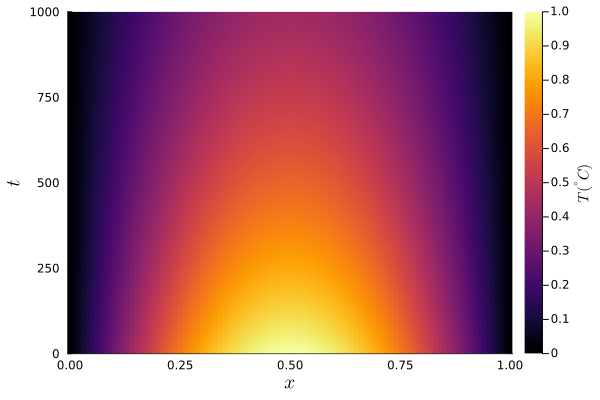

In [2]:
Δx = 0.01  # Spacing of the grid
Δt = 0.1  # Time spacing
nt = 10000  # Number of steps *after* the initial time.

L = 1.  # Length of the rod
K = 210.  # Thermal conductivity
C = 900.  # Specific heat capacity
ρ = 2700.  # Density

temperatures = heat_ftcs(Δx, Δt, nt, L, K, C, ρ)

temperatures = transpose(temperatures)  # Needed to plot the time in the vertical axis
boundary_points = [0. for _ in range(1, size(temperatures)[1])]
temperatures = [boundary_points temperatures boundary_points]  # Add the boundary x=0 for aesthetics.

x = range(0, 1, step=Δx)
t = range(0, step=0.1, length=10001)
temperature_heatmap = heatmap(x, t, temperatures, xlabel="\$ x \$", ylabel="\$ t\$", 
                              colorbar_title="\$T \\;(^{\\circ}{C})\$", dpi=600, labelfontsize=13)

# savefig(temperature_heatmap, "temperature_heatmap.png")

### Animation

In [150]:
# Must run previous cell

bar_limits = (-10, 15)

t_animation = range(7, 12)

t_animation_hold = range(-2, -1.99, length=2)
temperature_time_hold = [temperatures[1, i] for _ in t_animation_hold, i in range(1, size(x)[1])]

time_size = size(temperatures)[1]  # Amount of time stamps at which we have the temperature.

frames = 9*30  # 9 seconds of animation at 30 fps

jump = trunc(Int, time_size/frames)

# jump2 = trunc(Int, time_size/(frames - (time_size ÷ jump + 1)))  # Get the remaining frames needed.

anim = Plots.Animation()

for j in range(1, time_size)
    
    if mod(j, jump) != 0 
        continue
    end

    temperature_time_slice = [temperatures[j, i] for _ in t_animation, i in range(1, size(x)[1])]

    time = round(Int, j*Δt)
    
    heatmap(x, t_animation, temperature_time_slice, xlabel="\$ x \$", ylabel="\$T \\;(^{\\circ}{C})\$",
            ylims=bar_limits, 
            yticks=([range(-10, 6, length=11);], 
                    ["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", 0.9, "1.0"]),
            title = "\$ t = $time \$", colorbar_title="\$T \\;(^{\\circ}{C})\$", labelfontsize=13, dpi=500)
    
    heatmap!(x, t_animation_hold, temperature_time_hold)
    
    plot!(x, 16*temperatures[j,:] .+ bar_limits[1], label=nothing)
    
    Plots.frame(anim)
    
end

gif(anim, "Metallic_rod_30_2.gif", fps=30);

┌ Info: Saved animation to 
│   fn = /Users/vgranados/Documents/Lectures_Master/Methods of Computational Physics/comphysics/Project4/Metallic_rod_30_2.gif
└ @ Plots /Users/vgranados/.julia/packages/Plots/FCUr0/src/animation.jl:137


# b) Study of the simulation error

## To do:

What else to do with the plots below?
1. Adjust the position of the legend
1. Try to see if it's possible to adjust a curve that explains the dip in error for $\Delta t_{best}$

## Analytical expression for the error

In [ ]:
function ftcs_analytic_error(Δx, t_final)
    
    ϵ_analytical = Float64[]

    nx = trunc(Int, L/Δx)
    U = [sqrt(2/nx)*sin(π*i*j/nx) for i in range(1, nx-1), j in range(1, nx-1)]
    T_initial = [initial_temperature(x, L) for x in range(Δx, step=Δx, length=nx-1)]

    for Δt in range(1e-3, 0.7, step=1e-3)
        
        nt = trunc(Int, t_final/Δt)
        a = Δt/(τ* Δx^2)

        λ = zeros(nx-1,nx-1)
        for i in range(1, nx-1)
            λ[i,i] = (1 - 2*a + 2*a*cos(i*π/nx))^(nt)
        end

        A = U*λ*U

        for i in range(1, nx-1)
            A[i,i] -= exp(-π^2 * nt*Δt /(L^2 * τ))
        end

        ϵ = sum(abs.(A*T_initial))/nx

        push!(ϵ_analytical, ϵ)

    end
    
    return ϵ_analytical
end

In [ ]:
t_final = 100.  # Time at which we evaluate the error

Δx2 = 0.008

Δx3 = 0.005

ϵ_analytical = ftcs_analytic_error(Δx, t_final)

ϵ_analytical2 = ftcs_analytic_error(Δx2, t_final)

ϵ_analytical3 = ftcs_analytic_error(Δx3, t_final)


time_tolerance = 0.1

Δt_values, ϵ_values = error_estimation(heat_ftcs, t_final, time_tolerance, Δx)

ftcs_error_estimates = plot(Δt_values, log.(ϵ_analytical), color=:blue, label="\$ \\Delta x = $Δx \$", 
                            legend=:topleft, dpi=600)
plot!(Δt_values, log.(ϵ_analytical2), color=:red, label="\$ \\Delta x = $Δx2 \$")
plot!(Δt_values, log.(ϵ_analytical3), color=:orange, label="\$ \\Delta x = $Δx3 \$")

plot!(Δt_values, log.(ϵ_values), xlabel="\$ \\Delta t \$", 
    ylabel="\$ \\log(\\epsilon[t \\approx $t_final])\$", 
    ls=:dot, lw=2.7, alpha=0.8, label=:none)

least_error, position = findmin(ϵ_values)

best_Δt = Δt_values[position]

vline!([best_Δt], label="\$ \\Delta t_{best} = $best_Δt \$", lw=1.5)
vline!([(Δx^2)/(2*K/(C*ρ))], label="\$ \\Delta t_{max} = 0.579 \$", lw=1.5)

# savefig(ftcs_error_estimates, "ftcs_error_estimates.png")

Just because it is not right away obvious, it doesn't mean that the limit is not there. For example, using a $\Delta t$ slightly larger than the limit might not have a problematic effect at $t = 100$, but if we run the calculation for longer...

In [ ]:
t_final = 1000
time_tolerance = 0.1

Δt_values, ϵ_values = error_estimation(heat_ftcs, t_final, time_tolerance, Δx, L, τ)

ftcs_error_estimates2 = plot(Δt_values, log.(ϵ_values), label=:none, 
                             xlabel="\$ \\Delta t \$", 
                             ylabel="\$ \\log(\\epsilon[t = $t_final])\$", 
                             ls=:dot, lw=2.7, dpi=600, legend=:topleft)

least_error, position = findmin(ϵ_values)

best_Δt = Δt_values[position]

vline!([best_Δt], label="\$ \\Delta t_{best} = $best_Δt \$", lw=1.5)
vline!([(Δx^2)/(2*K/(C*ρ))], label="\$ \\Delta t_{max} = 0.579 \$", lw=1.5)
# savefig(ftcs_error_estimates2, "ftcs_error_estimates2.png")

## c)

## Implicit Euler backward

In [ ]:
temperatures_ieb = implicit_euler_backward(Δx, L, a, nt);

temperatures_ieb = transpose(temperatures_ieb)  # Needed to plot the time in the vertical axis

boundary_points = [0. for _ in range(1, nt+1)]

temperatures_ieb = [boundary_points temperatures_ieb boundary_points]  # Add the initial point x=0 for aesthetics.

heatmap(temperatures_ieb, xlabel="Position on the rod \$ x \$", ylabel="Time step \$ t\$", 
colorbar_title="temperature value")

In [ ]:
isapprox(temperatures_ieb, temperatures, rtol=0.00003295)

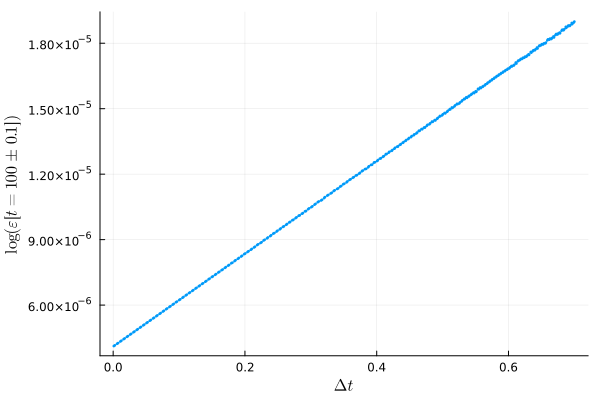

In [10]:
t_final = 100
time_tolerance = 0.1
Δx = 0.01
L = 1.

Δt_values, ϵ_values = error_estimation(implicit_euler_backward, t_final, time_tolerance, Δx)

plot(Δt_values, ϵ_values, label=:none, xlabel="\$ \\Delta t \$", 
     ylabel="\$ \\log(\\epsilon[t = $t_final \\pm $time_tolerance])\$", ls=:dot, lw=2.7, alpha=1.5)

# least_error, position = findmin(ϵ_values)

# best_Δt = Δt_values[position]

# vline!([best_Δt], label="\$ \\Delta t_{best} = $best_Δt \$")

In [11]:
τ/(6*100*100)

0.19285714285714284

## Crank-Nicolson

In [ ]:
temperatures_cn = crank_nicolson(Δx, L, a, nt);

temperatures_cn = transpose(temperatures_cn)  # Needed to plot the time in the vertical axis

boundary_points = [0. for _ in range(1, nt+1)]

temperatures_cn = [boundary_points temperatures_cn boundary_points]  # Add the points x=0, x=L for aesthetics.

heatmap(temperatures_cn, xlabel="Position on the rod \$ x \$", ylabel="Time step \$ t\$", 
colorbar_title="temperature value")

In [ ]:
isapprox(temperatures_cn, temperatures, rtol=0.0000165)

In [ ]:
isapprox(temperatures_ieb, temperatures_cn, rtol=0.0000165)

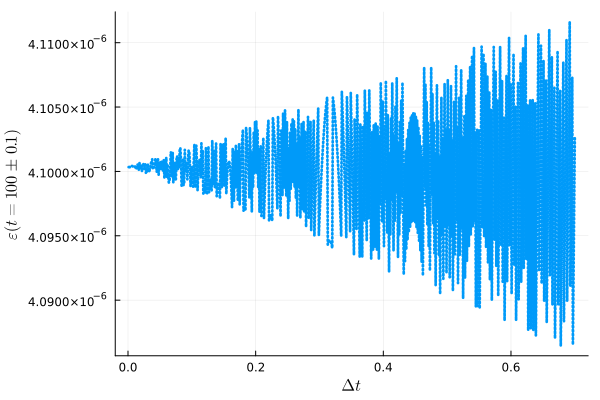

In [2]:
t_final = 100
time_tolerance = 0.1
Δx = 0.01
L = 1.

Δt_values, ϵ_values = error_estimation(crank_nicolson, t_final, time_tolerance, Δx)

plot(Δt_values, ϵ_values, label=:none, xlabel="\$ \\Delta t \$", 
     ylabel="\$ \\epsilon(t = $t_final \\pm $time_tolerance)\$", ls=:dot, lw=2.7, alpha=1.5)

# least_error, position = findmin(ϵ_values)

# best_Δt = Δt_values[position]

# vline!([best_Δt], label="\$ \\Delta t_{best} = $best_Δt \$")

## DuFort-Frankel

In [ ]:
Δx = 0.01
Δt = 0.1
nt = 10000

temperatures_df = dufort_frankel(Δx, Δt, nt)

temperatures_df = transpose(temperatures_df)  # Needed to plot the time in the vertical axis

boundary_points = [0. for _ in range(1, nt+1)]

temperatures_df = [boundary_points temperatures_df boundary_points]  # Add the points x=0, x=L for aesthetics.

heatmap(temperatures_df, xlabel="Position on the rod \$ x \$", ylabel="Time step \$ t\$", 
colorbar_title="temperature value")

In [ ]:
isapprox(temperatures_df, temperatures, rtol=0.00001365)

In [ ]:
isapprox(temperatures_cn, temperatures_df, rtol=0.00000285)

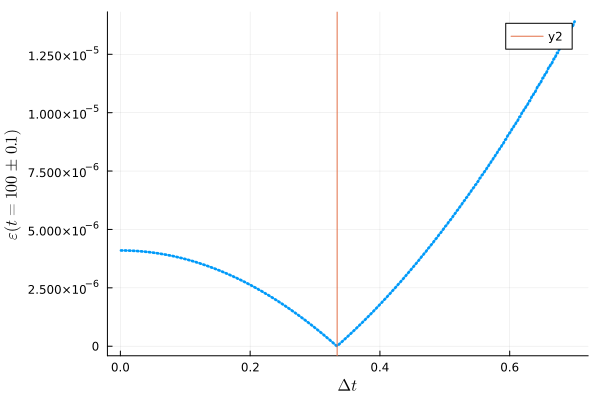

In [19]:
t_final = 100
time_tolerance = 0.1
Δx = 0.01
L = 1.

Δt_values, ϵ_values = error_estimation(dufort_frankel, t_final, time_tolerance, Δx)

plot(Δt_values, ϵ_values, label=:none, xlabel="\$ \\Delta t \$", 
     ylabel="\$ \\epsilon(t = $t_final \\pm $time_tolerance)\$", ls=:dot, lw=2.7, alpha=1.5)
vline!([change])

# least_error, position = findmin(ϵ_values)

# best_Δt = Δt_values[position]

# vline!([best_Δt], label="\$ \\Delta t_{best} = $best_Δt \$") 

In [14]:
factor1 = ((1/Δx)^2 - (π^2 / 6))* (210. / (900. * 2700.))^2
factor2 = (Δx)^2 / 12

change = sqrt(factor2/factor1)

0.33406584697574426

## To do:
   
   1. If time allows, try to implement Thomas algorithm instead of matrix inversion in implicit_euler_backward and implicit Crank-Nicolson.

   1. Check plots so far.
         1. Put error plots together

## Benchmarks for the different methods

In [4]:
Δx = 0.01
Δt = 0.1
nt = 10000

@benchmark heat_ftcs(Δx, Δt, nt)

BenchmarkTools.Trial: 7666 samples with 1 evaluation.
 Range (min … max):  337.708 μs …   2.100 ms  ┊ GC (min … max):  0.00% … 65.08%
 Time  (median):     567.041 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   650.876 μs ± 212.550 μs  ┊ GC (mean ± σ):  12.85% ± 17.51%

  ▃             ▆█▆▅▄▃▂                         ▁ ▁▁▂▂▃▂▁▁▂ ▁▂  ▁
  █▅▄▁▁▁▁▁▁▁▁▁▁▁████████▇▆▅▃▄▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▇█████████████ █
  338 μs        Histogram: log(frequency) by time       1.24 ms <

 Memory estimate: 7.55 MiB, allocs estimate: 3.

In [10]:
@benchmark implicit_euler_backward(Δx, Δt, nt)

BenchmarkTools.Trial: 282 samples with 1 evaluation.
 Range (min … max):  17.374 ms …  18.652 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.782 ms               ┊ GC (median):    0.50%
 Time  (mean ± σ):   17.765 ms ± 396.226 μs  ┊ GC (mean ± σ):  1.58% ± 1.92%

  ▁▆█                      ▁                                    
  ███▇▆▄▄▃▂▂▁▂▁▂▁▂▁▁▁▁▃▄▅▆██▇▄▄▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▆▄▅▅ ▃
  17.4 ms         Histogram: frequency by time         18.6 ms <

 Memory estimate: 24.73 MiB, allocs estimate: 20016.

In [9]:
@benchmark crank_nicolson(Δx, Δt, nt)

BenchmarkTools.Trial: 282 samples with 1 evaluation.
 Range (min … max):  17.348 ms …  18.860 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     17.713 ms               ┊ GC (median):    0.49%
 Time  (mean ± σ):   17.746 ms ± 420.272 μs  ┊ GC (mean ± σ):  1.71% ± 2.17%

   ██▃▁              ▃                                          
  ▇████▄▃▃▃▁▂▁▂▁▂▂▄▇▅█▆▇▆▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▄▃▅▅▆▄▂▃▂▃ ▃
  17.3 ms         Histogram: frequency by time         18.7 ms <

 Memory estimate: 24.80 MiB, allocs estimate: 20022.

In [8]:
@benchmark dufort_frankel(Δx, Δt, nt)

BenchmarkTools.Trial: 6977 samples with 1 evaluation.
 Range (min … max):  389.625 μs …   2.215 ms  ┊ GC (min … max):  0.00% … 69.07%
 Time  (median):     593.083 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   715.472 μs ± 294.398 μs  ┊ GC (mean ± σ):  16.44% ± 20.14%

           █▇▆▄▃▁                                ▂▂▂▂▂▂▁▁▁      ▂
  ▃▁▁▁▁▁▁▁▆███████▆▅▅▅▆▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄▆██████████████▇█ █
  390 μs        Histogram: log(frequency) by time        1.6 ms <

 Memory estimate: 7.55 MiB, allocs estimate: 3.